# Introduction to inference: hands on

Greg Ashton

https://github.com/GregoryAshton/GWParameterEstimationWorkshop2020

In [3]:
# Setup for the notebook: imports and set log levels to not produce too much output
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Bilby imports
import bilby
from bilby.core.likelihood import GaussianLikelihood
from bilby.core.prior import Uniform

# This is just to reduce the overall output, remove this when running locally
bilby.utils.setup_logger(log_level="WARNING")

# This is just to make things "pretty" for presentation
import seaborn
np.random.seed(123)
seaborn.set_context("talk")
seaborn.set_style("whitegrid")

## Installation

You need to install the relevant software, for this tutorial all you will need to do is run

```
$ pip install bilby
```

You can check this works by doing the following:

In [4]:
import bilby
print(bilby.__version__)

1.0.0: release


# Inference/Data analysis workshop: overview

- An aside on conditional probability and Bayes' theorem/one-liner
- Introduction to inference
- Inference from scratch
- Bilby as a black box
- Bilby likelihoods
- Bilby priors
- Bilby model selection

## An aside on conditional probability and Bayes' theorem/one-liner

- Throughout this tutorial, we'll be using the oft-talked about [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem):

$$ P(A|B) = \frac{P(B|A)P(A)}{P(B)} $$

- Before we begin, let's make sure we understand it

**Question:** What is the probability of drawing a red-suit card from a pack of 52 cards?

**Answer:** It is 1/2 *if* the 52-card deck of cards is regular

**Question:** How do you express that mathematically?

**Answer:**

$$ P(\textrm{red-card} | I) = \frac{1}{2} $$

where

$$ I \equiv \textrm{"normal 52-card deck"} $$

is our *background* information.

*The vertical line above can be read as "given"*

**Question:** What is the probability of drawing <span style="color:red"> 2 red-suit card from a pack of 52 cards</span>?

**Answer:** Uhh.. hang on let me draw a diagram
```
           O      
        /     \
       /       \
      R0       B0
      / \      /\
     /   \    /  \
    R1   B1  R1  B1
```

So...
$$R_0 = \frac{26}{52}=\frac{1}{2} \;\; \textrm{ and }\;\; R_1=\frac{26-1}{52-1}=\frac{25}{51}$$
so the probability of both occuring is 
$$ R_1 \times R_0 = \frac{25}{102} $$

**Question:** How do you express that mathematically?

**Answer:** We want $P(R_0, R_1| I)$, so we need to use *conditional probability*

$$ P(R_0, R_1| I) = P(R_1 | R_0, I) P(R_0| I) $$

with
$$ P(R_0 | I) = \frac{1}{2} $$
and
$$ P(R_1 | R_0, I) = \frac{\textrm{Number of red cards}}{\textrm{Number of cards}} = \frac{26-1}{52-1} = \frac{25}{51} $$

And so finally
$$ P(R_0, R_1| I) = \frac{1}{2} \times \frac{25}{51} = \frac{25}{102}$$

### Okay sorry, where were we?

You all understand conditional probability 
$$P(A, B| I ) = P(A| B, I)P(B, I)$$

But we can write that the other way around
$$P(A, B| I ) = P(B| A, I)P(A, I)$$

Then with a little algebra

$$ P(A| B, I) = \frac{P(B| A, I) P(A| I)}{P(B| I)} $$

- Which is just... Bayes' theorem.

- Maybe we should just call it Bayes' one-liner?

## Introduction to Inference

- **Inference is about figuring something out from the data**

- We will label, for now, our data as $\textbf{data}$

- Once you have some data it is time to decide what you want to figure out.

- Inference can be thought of in two ways:
  1. **Parameter estimation**: "*I want to figure our what model parameters $\theta$ best-fit my data, given some model $M_A$*"
  2. **Model selection**: "*I want to figure our which model, $M_A$ or $M_B$ best fits my data*"

## Parameter Estimation

Parameter estimation is about figuring out the model parameters $\theta$ given some model $M_A$

$$ P(\theta| M_A, \mathbf{data}) = \frac{P(\mathbf{data}| M_A, \theta) P(\theta | M_A)}{P(\mathbf{data} | M_A)}$$

The denomoninator here only normalises the distribution, so often people will simplify

$$ P(\theta| M_A, \mathbf{data}) \propto P(\mathbf{data}| M_A, \theta) P(\theta | M_A)$$

For consistency with notation elsewhere, this is often written

$$ \underbrace{P(\theta| M_A, \mathbf{data})}_{\textrm{posterior}} \propto \underbrace{\mathcal{L}(\mathbf{data}| M_A, \theta)}_{\textrm{likelihood}} \underbrace{\pi(\theta | M_A)}_{\textrm{prior}}$$

### Example 1: one-dimensional posterior distribution

Let's talk about some specific data $\mathbf{y} = [y_0, y_1, \ldots, y_N]$ observed at times $\mathbf{t} = [t_0, t_1, \ldots, t_N]$.

To be concrete: we will say

- Our model is
$$ M_A: y_A(t; \omega) = \sin(\omega t) $$
- We have one model parameter, i.e. $\mathbf{\theta}=[\omega]$

In [6]:
def modelA(time, omega):
    return np.sin(omega * time)

Okay, let's simulate some data

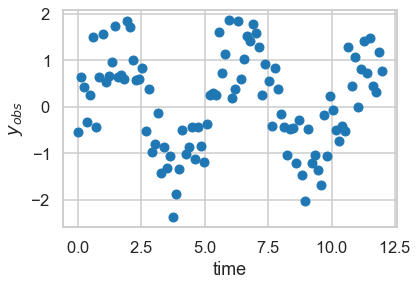

In [7]:
sigma = 0.5
omega_true = 1.2
time = np.linspace(0, 12, 100)
ydet = modelA(time, omega=omega_true)
yobs = ydet + np.random.normal(0, sigma, len(time))  # Observed data = SIGNAL + GAUSSIAN NOISE

plt.plot(time, yobs, "o")
plt.ylabel("$y_{obs}$"); plt.xlabel("time")
plt.show()

We want to *figure something out from the data*. Let's figure out the frequency

The *noise* is Gaussian, i.e. we have

$$ y_\textrm{obs} = y_\textrm{det} + \textrm{noise} => \textrm{noise} = y_\textrm{obs} - y_\textrm{det}$$

So, if we have a single data point $y_i, t_i$, then given a particular $\omega$

$$\mathcal{L}(y_i, t_i | \omega, M_A, \sigma=0.1) = \textrm{Normal}(y - y_A(t; \omega); \sigma=0.1) 
= \frac{1}{\sqrt{2\pi\sigma^2}} \mathrm{exp}\left(-\frac{(y_i-y(t_i)^2)}{2\sigma^2}\right)$$

It is a good idea to work with the log-likelihood
$$ \ln\mathcal{L}(y_i, t_i | \omega, M_A, \sigma=0.1) = -\frac{1}{2}\left(
\frac{(y_i-y_A(t_i))^2}{\sigma^2} + \ln({2\pi\sigma^2})
\right)$$

Last, we want the likelihood from **all** the data:
$$\mathcal{L}(\mathbf{y}, \mathbf{t} | \omega, M_A, \sigma=0.1) = \prod_{i}\mathcal{L}(y_i, t_i | \omega, M_A, \sigma=0.1)$$
or
$$\ln\mathcal{L}(\mathbf{y}, \mathbf{t} | \omega, M_A, \sigma=0.1) = \sum_{i}\ln\mathcal{L}(y_i, t_i | \omega, M_A, \sigma=0.1)$$

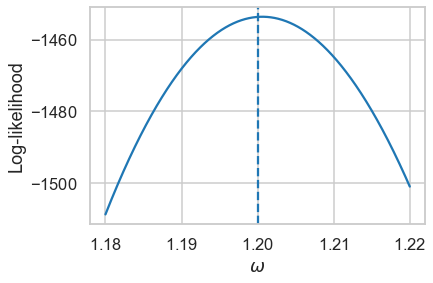

In [8]:
def ln_likelihood(yobs, time, omega, sigma=0.1):
    yA = modelA(time, omega)
    ln_likes = -0.5 * ((yobs - yA)**2 / sigma**2 + np.log(2*np.pi*sigma**2))
    return np.sum(ln_likes)

omega_grid = np.linspace(omega_true-2e-2, omega_true+2e-2, 1000)
ln_likelihood_grid = []
for omega in omega_grid:
    ln_likelihood_grid.append(ln_likelihood(yobs, time, omega))
    
plt.plot(omega_grid, ln_likelihood_grid)
plt.axvline(omega_true, ls='--')
plt.xlabel("$\omega$")
plt.ylabel("Log-likelihood")
plt.show()

### Max likelihood

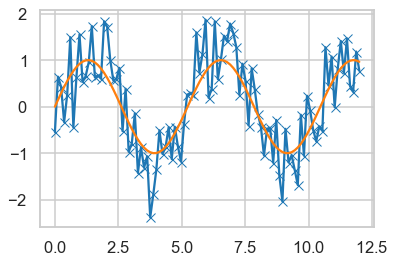

In [9]:
max_likelihood_omega = omega_grid[np.argmax(ln_likelihood_grid)]
plt.plot(time, yobs, '-x')
plt.plot(time, modelA(time, max_likelihood_omega))
plt.show()

## Posteriors

$$ P(\omega | \mathrm{data}) \propto \mathcal{L}(\mathrm{data}| \omega) \times \pi(\omega) $$

- If $\pi(\omega) \propto \textrm{const.}$, then $P(\omega | \mathrm{data}) \propto \mathcal{L}(\mathrm{data}| \omega)$
- If not, then one needs to do multiply by the prior.
- For the time being let's take the easier case

### Normalised posterior density function (pdf)

Let's plot the posterior (equal to the likelihood in this case) taking an exponent

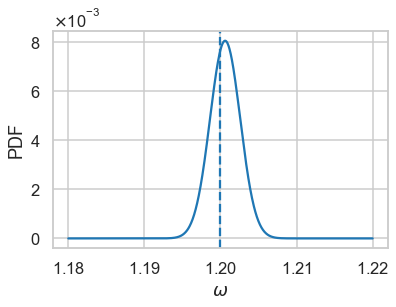

In [10]:
pdf_unnormalized = np.exp(ln_likelihood_grid - np.mean(ln_likelihood_grid))
pdf_normalized = pdf_unnormalized / np.sum(pdf_unnormalized)
plt.plot(omega_grid, pdf_normalized)
plt.axvline(omega_true, ls='--')
plt.xlabel("$\omega$")
plt.ylabel("PDF")
plt.show()

### Why is the peak not consistent with the true value?

- Cleary the median of this distribution does **not** agree with the true value
- The *noise* in the observed data means that we have uncertainty!
- How can be quantify this?
- Bayesian answer is the [credible interval](https://en.wikipedia.org/wiki/Credible_interval) 
- We should always report inferences as $\omega$ has a median of XX and lies between YY and ZZ with 95\% probability
- How do we figure out these numbers?

## Cumulative distribution

First, let's calculate the cumulative distribution function

$$ \mathrm{CDF}(\omega) = \int_{-\infty}^{\omega} P(\omega'| \mathrm{data})\, d\omega' $$

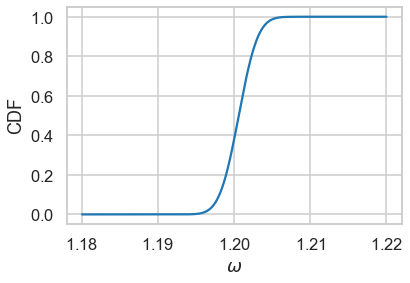

In [11]:
cdf = np.cumsum(pdf_normalized)
plt.plot(omega_grid, cdf)
plt.xlabel("$\omega$")
plt.ylabel("CDF")
plt.show()

- The median is the point where the CDF passes through 0.5
- We can find the 90% confidence interval by finding the 0.05 and 0.95 numbers (such that the interval contains 90% of the probability)

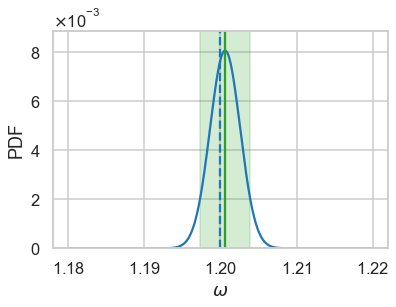

In [12]:
median = omega_grid[np.argmin(np.abs(cdf - 0.5))]
low_bound = omega_grid[np.argmin(np.abs(cdf - 0.05))]
upper_bound = omega_grid[np.argmin(np.abs(cdf - 0.95))]

plt.plot(omega_grid, pdf_normalized)
plt.axvline(omega_true, ls='--')
plt.fill_between([low_bound, upper_bound], 0, 2 * np.max(pdf_normalized), color='C2', alpha=0.2)
plt.axvline(median, color='C2')
plt.ylim(0, 1.1 * np.max(pdf_normalized)); plt.xlabel("$\omega$"); plt.ylabel("PDF")
plt.show()

## What happens when things get more complicated?

- In low-dimensions, evaluating a grid of points isn't too crazy
- In high-dimensionl problems, the number of grid points scales with the number of dimensions!
- Here we turn to stochastic sampling algorithms

## First, let's build a peak-finding algorithm


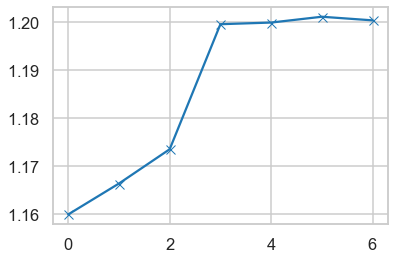

In [13]:
omega_values = [1.16] # Pick a starting point
ln_likelihood_values = [ln_likelihood(yobs, time, omega_values[0])]

for i in range(100):
    proposed_point = omega_values[-1] + np.random.normal(0, 0.01)
    ln_likelihood_proposed = ln_likelihood(yobs, time, proposed_point)
    
    if ln_likelihood_proposed > ln_likelihood_values[-1]:
        omega_values.append(proposed_point)
        ln_likelihood_values.append(ln_likelihood_proposed)
        
plt.plot(omega_values, '-x')
plt.show()

- Good at finding the peak of a unimodel likelihood to arbitrary precision
- Bad if things are multimodal
- Doesn't tell us anything about the "structure"

### Very basic Metropolis-Hastings sampler

Markov-Chain Monte-Carlo samplers use "randomness" to sample from the posterior distribution

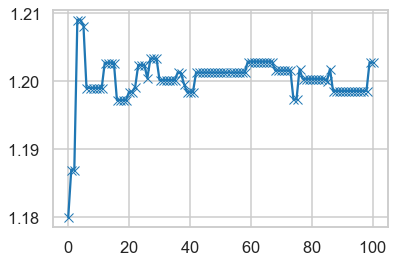

In [14]:
omega_values = [1.18] # Pick a starting point
ln_likelihood_values = [ln_likelihood(yobs, time, omega_values[0])]

for i in range(100):
    proposed_point = omega_values[-1] + np.random.normal(0, 0.01)
    ln_likelihood_proposed = ln_likelihood(yobs, time, proposed_point)
    
    if ln_likelihood_proposed > ln_likelihood_values[-1] + np.log(np.random.rand()):
        omega_values.append(proposed_point)
        ln_likelihood_values.append(ln_likelihood_proposed)
    else:
        omega_values.append(omega_values[-1])
        ln_likelihood_values.append(ln_likelihood_values[-1])
        
plt.plot(omega_values, '-x')
plt.show()

### Run it with a few more steps...

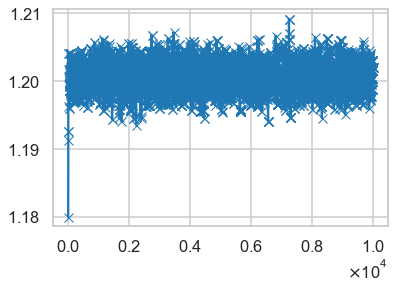

In [15]:
omega_values = [1.18] # Pick a starting point
ln_likelihood_values = [ln_likelihood(yobs, time, omega_values[0])]

for i in range(10000):
    proposed_point = omega_values[-1] + np.random.normal(0, 0.01)
    ln_likelihood_proposed = ln_likelihood(yobs, time, proposed_point)
    
    if ln_likelihood_proposed > ln_likelihood_values[-1] + np.log(np.random.rand()):
        omega_values.append(proposed_point)
        ln_likelihood_values.append(ln_likelihood_proposed)
    else:
        omega_values.append(omega_values[-1])
        ln_likelihood_values.append(ln_likelihood_values[-1])
        
plt.plot(omega_values, '-x')
plt.show()

### Histogram the samples

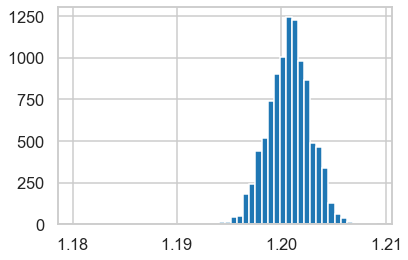

In [17]:
_ = plt.hist(omega_values, bins=50)

## Sampling takeaways

- Stochastic samplers are all about drawing "samples" from the posterior distribution

- Simple MCMC methods need tuning

- Advanced MCMC methods have fewer tuning parameters
  - Parallel tempering is required to deal with multi-model distributions
  - Can calculate evidences, but not advised
  
- Nested Sampling is better than MCMC
  - Calculated evidences by design
  - Deals well with multimodal distributions

## Using Bilby

- Bilby is a generic Bayesian inference library
- Special support for Gravitational-Wave Transient's (focus of this workshop)
- First, let's introduce it in a simple setting

<img src="https://git.ligo.org/uploads/-/system/project/avatar/1846/bilby.jpg?width=64" alt="drawing" width="200"/>

## Bilby provides a easy-to-use interface for common inference tasks

Let's repeat what we did above, but in bilby

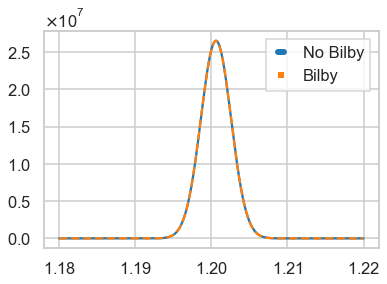

In [18]:
likelihood = bilby.likelihood.GaussianLikelihood(time, yobs, modelA, sigma=0.1)

ln_likelihood_grid_bilby = []
for omega in omega_grid:
    likelihood.parameters["omega"] = omega
    ln_likelihood_grid_bilby.append(likelihood.log_likelihood())
    
plt.plot(omega_grid, np.exp(ln_likelihood_grid - np.mean(ln_likelihood_grid)), label="No Bilby")
plt.plot(omega_grid, np.exp(ln_likelihood_grid_bilby - np.mean(ln_likelihood_grid_bilby)), '--', label="Bilby")
plt.legend()
plt.show()

## Increasing complexity

- What happens if we increase the complexity?
- What if our model looks like this

$$ y_B(t) = A\sin(\omega t + \phi_0)$$

- And we don't know what $\sigma$ is?

We **could** repeat the operation above:
- Create a grid (now in 4D)
- Evaluate the likelihood over the grid and find a maximum

**But**: the number of grid point we need is $\propto (\textrm{the grid spacing})^N$

## Stochastic Sampling methods: as a black box

In [19]:
def modelB(time, omega, A, phi0):
    return A * np.sin(omega * time + phi0)

likelihood = bilby.likelihood.GaussianLikelihood(time, yobs, modelB)

priors = dict(
    A=Uniform(0, 2, "A"),
    omega=Uniform(1, 1.5, "omega"),
    phi0=Uniform(-np.pi, np.pi, "phi0", boundary='reflective'),
    sigma=Uniform(0, 2, "sigma"))

result = bilby.run_sampler(
    likelihood, priors=priors, nlive=500, sample='unif', outdir="test-outdir", label="black-box",
    injection_parameters=dict(A=1, omega=omega_true, phi0=0, sigma=sigma),
    clean=True)

6876it [00:14, 461.15it/s, bound:44 nc:  1 ncall:3.1e+04 eff:23.7% logz=-92.04+/-0.20 dlogz:0.000>0.1]  



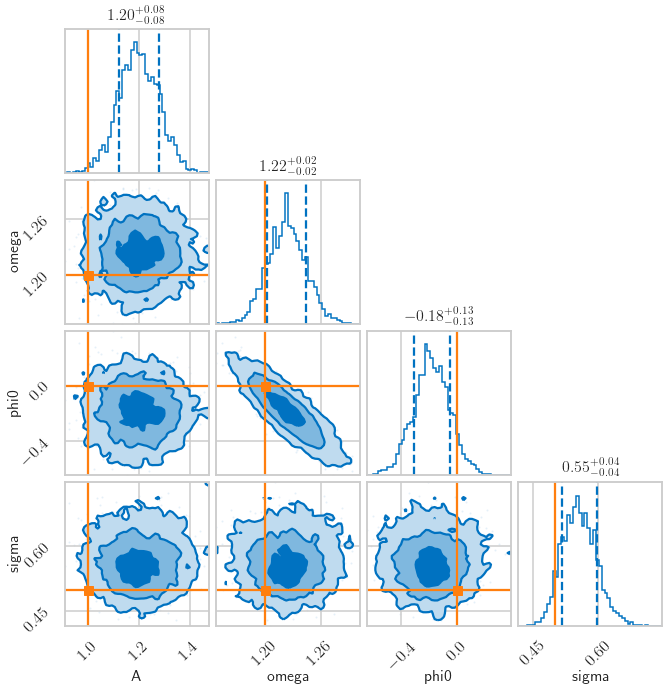

In [20]:
# Dashed lines give 90% C.I.
result.plot_corner()

# What is going on here?

- Bilby has used a [Nested Sampling](https://en.wikipedia.org/wiki/Nested_sampling_algorithm) algorithm [dynesty](https://dynesty.readthedocs.io/en/latest/) to evaluate the posteriors
- The posterior output are a set of samples
- The samples are "points drawn from the posterior distribution"
- Stored in a pandas DataFrame

In [21]:
result.posterior.head()

,A,omega,phi0,sigma,log_likelihood,log_prior
0,1.469067,1.211196,-0.207780,0.746758,-92.909864,-2.531024
1,1.098518,1.201314,-0.351461,0.554140,-91.746937,-2.531024
2,1.347732,1.202037,-0.116126,0.431332,-91.169481,-2.531024
3,1.259033,1.274326,-0.409933,0.443840,-90.879061,-2.531024
4,0.921740,1.227702,-0.270469,0.699847,-90.556848,-2.531024


## Using the samples

You can use the samples in all sorts of ways, for example let's plot the 1D marginalised distribution for omega

(0.0, 25.0)

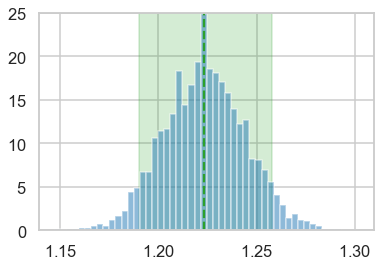

In [22]:
omega_samples = result.posterior["omega"]
median = np.quantile(omega_samples, 0.5)
low_bound = np.quantile(omega_samples, 0.05)
upper_bound = np.quantile(omega_samples, 0.95)

plt.fill_between([low_bound, upper_bound], 0, 200, color='C2', alpha=0.2)
plt.axvline(median, ls="--", color="C2")
_ = plt.hist(omega_samples, bins=50, density=True, alpha=0.5)
plt.ylim(0, 25)

### Looking at the posterior uncertainty
We might want to know what range of curves are data supports

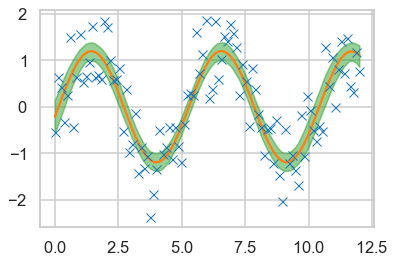

In [23]:
y_pred = []
for _, sample in result.posterior.sample(1000).iterrows():
    y_pred.append(modelB(time, **{k:sample[k] for k in likelihood.model_parameters.keys()}))
    
median = np.quantile(y_pred, 0.5, axis=0)
lower = np.quantile(y_pred, 0.01, axis=0)
upper = np.quantile(y_pred, 0.99, axis=0)
plt.plot(time, median, color='C1')
plt.fill_between(time, lower, upper, color="C2", alpha=0.5)

plt.plot(time, yobs, 'x')
plt.show()

## Using the `results` objects

The `result` object is where all the output is stored. It is stored to disk (by default in a `json` format)

In [24]:
print(result.outdir)  # Set in the `run_sampler()` call

/home/user1/GWParameterEstimationWorkshop2020/notebooks/test-outdir


In [25]:
!ls /home/user1/test-outdir

black-box_1d			black-box_plot_with_data.png
black-box_checkpoint_trace.png	black-box_result.json
black-box_corner.png		black-box_resume.pickle
black-box_dynesty.pickle


In [26]:
!head /home/user1/test-outdir/black-box_result.json

{
  "label": "black-box",
  "outdir": "/home/user1/test-outdir",
  "sampler": "dynesty",
  "log_evidence": -78.89969252798156,
  "log_evidence_err": 0.1980948729047665,
  "log_noise_evidence": NaN,
  "log_bayes_factor": NaN,
  "priors": {
    "A": {


## You can load the result up

In [27]:
result_loaded = bilby.result.read_in_result("test-outdir/black-box_result.json")

## Check a traceplot of the runs

display: test-outdir/black-box_checkpoint_trace.png

![image](test-outdir/black-box_checkpoint_trace.png)

## Access attributes

In [28]:
print(result_loaded.log_evidence)
print(result_loaded.injection_parameters)
print(result_loaded.sampling_time)  # In seconds
print(result.version)

-92.0413433496363
{'A': 1, 'omega': 1.2, 'phi0': 0, 'sigma': 0.5}
9.574038
bilby=1.0.0: release


## Make corner plots with truths

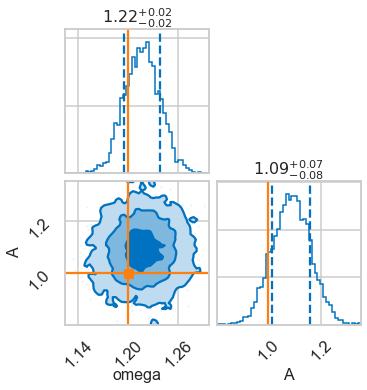

In [34]:
result.plot_corner(dict(omega=omega_true, A=1))

## Make corner plots without truths

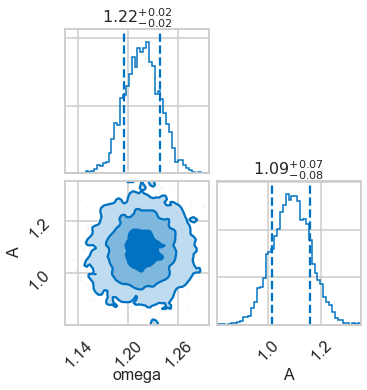

In [35]:
result.plot_corner(['omega', 'A'])

## Priors

- Bilby includes lots of built in priors
- Like the likelihood you can create your own from scratch

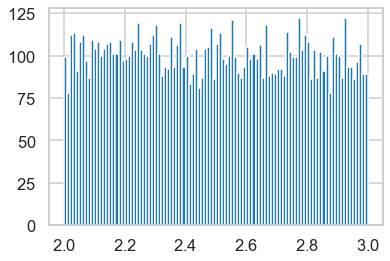

In [31]:
log_unif = bilby.core.prior.Uniform(2, 3)
_ = plt.hist(log_unif.sample(10000), bins=100)

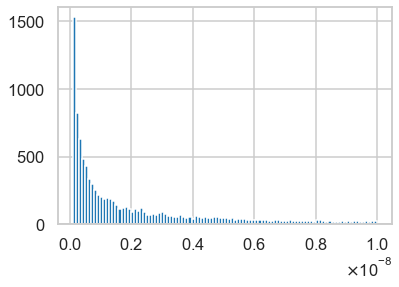

In [32]:
log_unif = bilby.core.prior.LogUniform(1e-10, 1e-8)
_ = plt.hist(log_unif.sample(10000), bins=100)

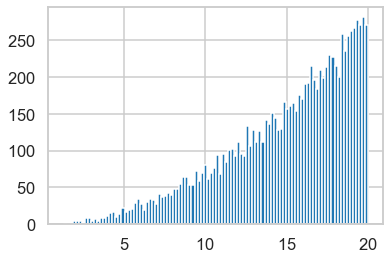

In [33]:
power = bilby.core.prior.PowerLaw(alpha=2, minimum=1, maximum=20)
_ = plt.hist(power.sample(10000), bins=100)

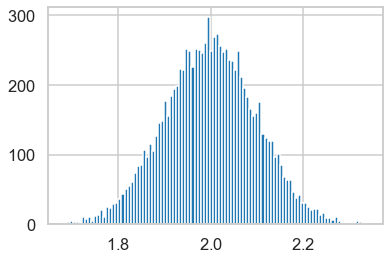

In [34]:
gauss = bilby.core.prior.Gaussian(mu=2, sigma=0.1)
_ = plt.hist(gauss.sample(10000), bins=100)

### We also provide the `PriorDict` which is useful for handling a set of priors

In [35]:
priors = bilby.prior.PriorDict(dict(
    x=bilby.prior.Uniform(0, 1, 'x'),
    y=bilby.prior.Cosine('y')))
prior_samples = priors.sample(10000)
prior_samples

{'x': array([0.45140424, 0.58268446, 0.34506639, ..., 0.82041859,
        0.85754822, 0.21071136]),
 'y': array([0.65367579, 0.16724179, 0.23514989, ..., 0.89230089,
        0.92437386, 0.65387593])}

## Plotting the prior samples

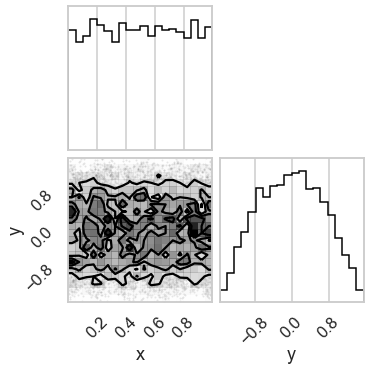

In [36]:
import corner
prior_samples_array = np.array([prior_samples['x'], prior_samples['y']]).T
corner.corner(prior_samples_array, labels=['x', 'y'])
plt.show()

## Additional resources

- Greg Ashton's [OzGrav ECR slides](https://github.com/GregoryAshton/Inference-Data-analysis-hands-on-training) on which these where based.

- Moritz Hübner's introduction to bilby [on colab](https://colab.research.google.com/drive/1PiQD4ZVA-cteqpcrhEZThkY9BLJAsdrK)

- Colm Talbot's introduction to GW inference with bilby [on colab](https://colab.research.google.com/gist/ColmTalbot/58dacd07a820d96ed0e1c43e2bf824c1/gravitational-wave-transient-inference-with-bilby.ipynb)